## Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Imports ###

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label
from skimage.feature import hog
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
from sklearn.ensemble import RandomForestClassifier


%matplotlib inline

### Dataset Visualization ###

In [2]:
# glob our dataset
cars = glob.glob('VehicleData/vehicles/*/*.png')
noncars = glob.glob('VehicleData/non-vehicles/*/*.png')

# print out number of images
print("Number of Vehicle Images: {0}".format(len(cars)))
print("Number of Non-Vehicle Images: {0}".format(len(noncars)))

Number of Vehicle Images: 8792
Number of Non-Vehicle Images: 8968


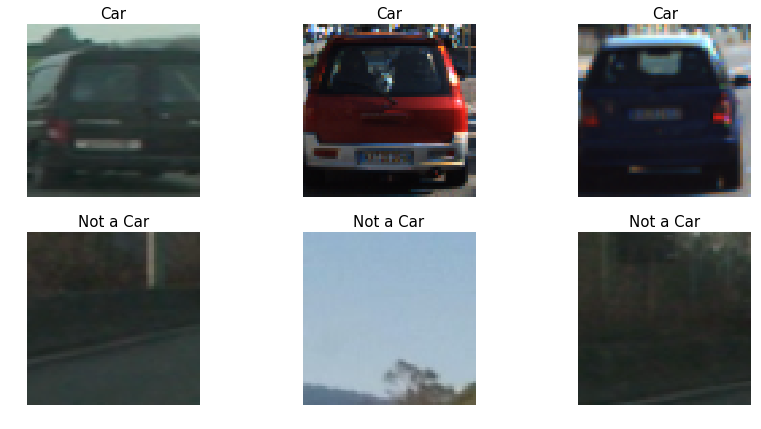

In [3]:
# Note:classes are well balanced
# now let's visualize a few of each class

f, axarr = plt.subplots(2, 3, figsize=(14, 7))
for i in range(3):
    img = mpimg.imread(cars[np.random.randint(0,len(cars))])
    axarr[0,i].set_title('Car', fontsize=15)
    axarr[0,i].axis('off')
    axarr[0,i].imshow(img)
for i in range(3):
    img = mpimg.imread(noncars[np.random.randint(0,len(noncars))])
    axarr[1,i].set_title('Not a Car', fontsize=15)
    axarr[1,i].axis('off')
    axarr[1,i].imshow(img)
f.savefig('./output_images/plot1.png')

### Feature Extraction - HOG, Spatial, and Color ##

In [4]:
# put in useful functions for feature extraction of HOG, spatial, and color
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

#Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Visualize HOG Features ###

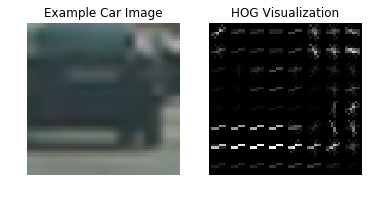

In [5]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.axis('off')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.axis('off')
plt.title('HOG Visualization')
plt.savefig('./output_images/hog1.png')

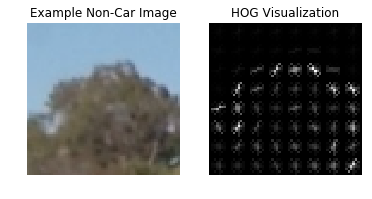

In [6]:
# Generate a random index to look at a non-car image
ind = np.random.randint(0, len(noncars))
# Read in the image
image = mpimg.imread(noncars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Non-Car Image')
plt.axis('off')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.axis('off')
plt.title('HOG Visualization')
plt.savefig('./output_images/hog2.png')

### Feature Set Parameters ###

In [7]:
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 2 # Can be 0, 1, 2, or "ALL"
spatial_size = (8, 8) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [8]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(noncars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# print out basic info of feature set
print("Number of Car Features is: {0}".format(len(car_features)))
print("Number of Non-Car Features is: {0}".format(len(notcar_features)))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

Number of Car Features is: 8792
Number of Non-Car Features is: 8968


In [9]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=1.)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
#t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2148
4.51 Seconds to train SVC...
Test Accuracy of SVC =  0.9893


In [10]:
# Use a Random Forest
RF = RandomForestClassifier(max_depth=5, n_estimators=20)
# Check the training time for the Random Forest
t=time.time()
RF.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train Random Forest...')
# Check the score of the random forest
print('Test Accuracy of Random Forest = ', round(RF.score(X_test, y_test), 4))

4.32 Seconds to train Random Forest...
Test Accuracy of Random Forest =  0.9797


We will go with Linear SVC.

Random Forest is beaten by Linear SVC by a relatively large margin.


### Sliding Window Code ###

In [11]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Explore Multiscale Windows ###

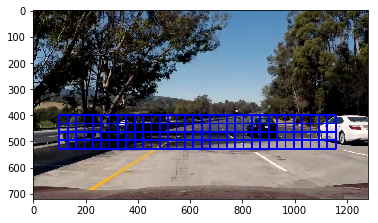

In [12]:
pict = mpimg.imread('./test_images/test5.jpg')
out_pict = np.copy(pict)



x_start_stop = [100, 1180]
y_start_stop = [400, 550]
xy_window = (64, 64)
xy_overlap = (0.5, 0.5)

win = slide_window(out_pict, x_start_stop, y_start_stop, xy_window, xy_overlap)
out_pict = draw_boxes(out_pict, win)
plt.imshow(out_pict)
plt.savefig('./output_images/level1.png')

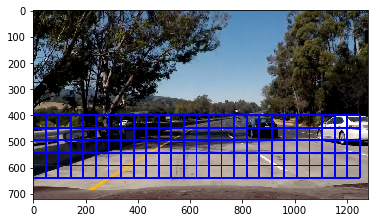

In [13]:
out_pict = np.copy(pict)



x_start_stop = [None, None]
y_start_stop = [400, 650]
xy_window = (96, 96)
xy_overlap = (0.5, 0.5)

win = slide_window(out_pict, x_start_stop, y_start_stop, xy_window, xy_overlap)
out_pict = draw_boxes(out_pict, win)
plt.imshow(out_pict)
plt.savefig('./output_images/level2.png')

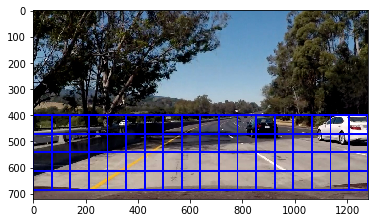

In [14]:
out_pict = np.copy(pict)



x_start_stop = [None, None]
y_start_stop = [400, 690]
xy_window = (142,142)
xy_overlap = (0.5, 0.5)

win = slide_window(out_pict, x_start_stop, y_start_stop, xy_window, xy_overlap)
out_pict = draw_boxes(out_pict, win)
plt.imshow(out_pict)
plt.savefig('./output_images/level3.png')

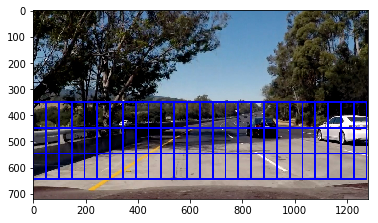

In [15]:
out_pict = np.copy(pict)



x_start_stop = [None, None]
y_start_stop = [350, 700]
xy_window = (196,196)
xy_overlap = (0.75, 0.5)

win = slide_window(out_pict, x_start_stop, y_start_stop, xy_window, xy_overlap)
out_pict = draw_boxes(out_pict, win)
plt.imshow(out_pict)
plt.savefig('./output_images/level4.png')

### Find Cars Code ###

In [54]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, 
              svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins, visualize_rectangles=False):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    detected_rectangles = []
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2HSV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    if hog_channel == "ALL":
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1 #cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1 # cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == "ALL":
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == "ALL":
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1
                
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            subimg = ctrans_tosearch[ytop:ytop+window, xleft:xleft+window]
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or visualize_rectangles:
                xbox_left = np.int(xleft*scale) + xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart)),(0,255,0),6)
                detected_rectangles.append(((int(xbox_left), int(ytop_draw+ystart)), (int(xbox_left+win_draw), int(ytop_draw+win_draw+ystart))))
                
    return detected_rectangles, draw_img
    

### Detect Small Scale Grids ###

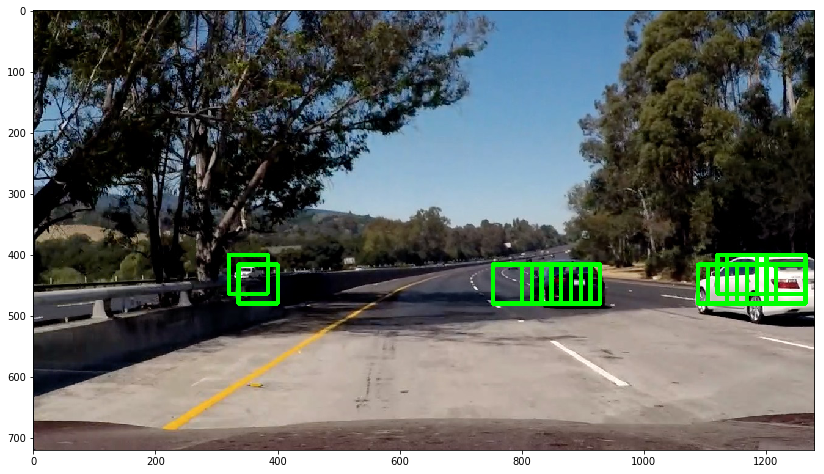

In [91]:
pict = mpimg.imread('./test_images/test5.jpg')
out_pict = np.copy(pict)

rectangles = []

ystart = 400
ystop = 500
xstart = 0
xstop = 1280
scale = 1.

rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                     svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                     spatial_size, hist_bins, visualize_rectangles=False)

rectangles.extend(rects)
test_out_img = draw_boxes(out_pict, rectangles, color=(0, 255, 0))
plt.figure(figsize=(14,14))
plt.imshow(test_out_img)
plt.savefig('./output_images/small_grid.png')

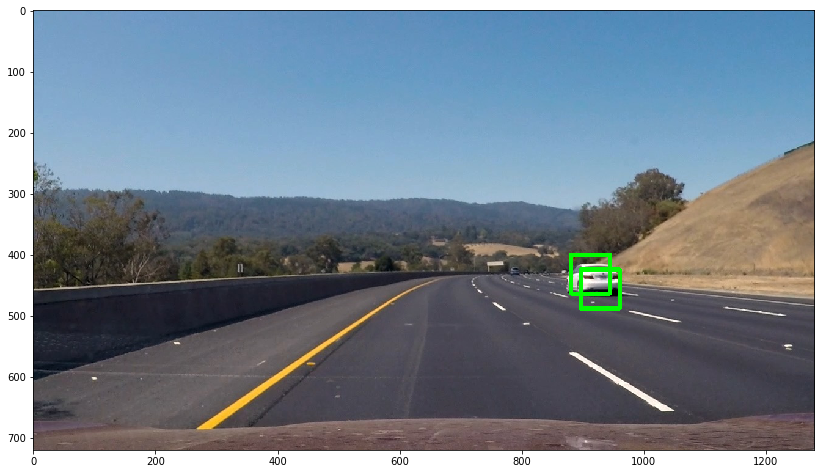

In [90]:
pict = mpimg.imread('./test_images/test3.jpg')
out_pict = np.copy(pict)

rectangles = []

ystart = 400
ystop = 500
xstart = 0
xstop = 1280
scale = 1.

rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                     svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                     spatial_size, hist_bins, visualize_rectangles=False)
rectangles.extend(rects)

ystart = 424
ystop = 524
xstart = 0
xstop = 1280
scale = 1.

rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                     svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                     spatial_size, hist_bins, visualize_rectangles=False)

rectangles.extend(rects)
test_out_img = draw_boxes(out_pict, rectangles, color=(0, 255, 0))
plt.figure(figsize=(14,14))
plt.imshow(test_out_img)
plt.savefig('./output_images/small_grid-2.png')

### Detect Larger Scale Grids ###

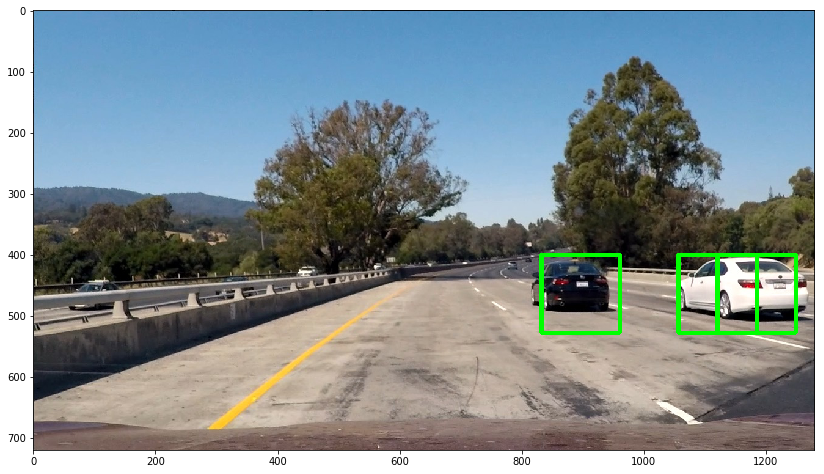

In [93]:
pict = mpimg.imread('./test_images/test1.jpg')
out_pict = np.copy(pict)

rectangles = []

ystart = 400
ystop = 700
xstart = 0
xstop = 1280
scale = 2.

rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                     svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                     spatial_size, hist_bins, visualize_rectangles=False)
rectangles.extend(rects)

ystart = 450
ystop = 700
xstart = 0
xstop = 1280
scale = 2.

rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                     svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                     spatial_size, hist_bins, visualize_rectangles=False)

rectangles.extend(rects)
test_out_img = draw_boxes(out_pict, rectangles, color=(0, 255, 0))
plt.figure(figsize=(14,14))
plt.imshow(test_out_img)
plt.savefig('./output_images/large_grid-1.png')

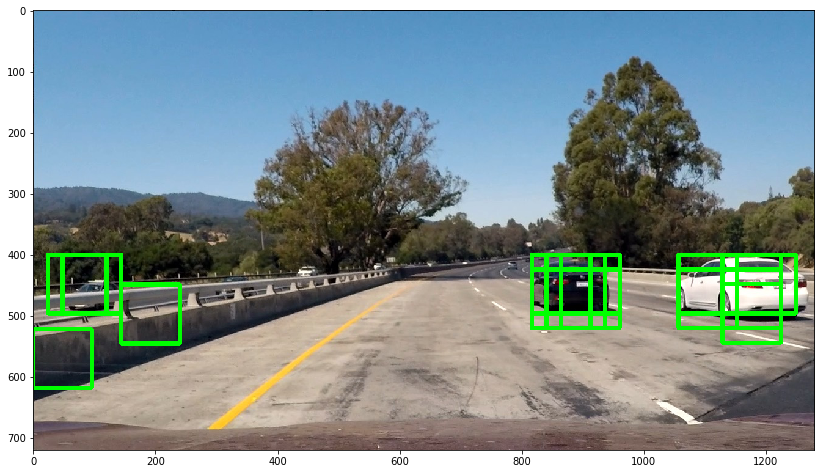

In [109]:
pict = mpimg.imread('./test_images/test1.jpg')
out_pict = np.copy(pict)

rectangles = []

ystart = 400
ystop = 700
xstart = 0
xstop = 1280
scale = 1.5

rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                     svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                     spatial_size, hist_bins, visualize_rectangles=False)
rectangles.extend(rects)

ystart = 450
ystop = 700
xstart = 0
xstop = 1280
scale = 1.5

rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                     svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                     spatial_size, hist_bins, visualize_rectangles=False)

rectangles.extend(rects)
test_out_img = draw_boxes(out_pict, rectangles, color=(0, 255, 0))
plt.figure(figsize=(14,14))
plt.imshow(test_out_img)
plt.savefig('./output_images/large_grid-2.png')

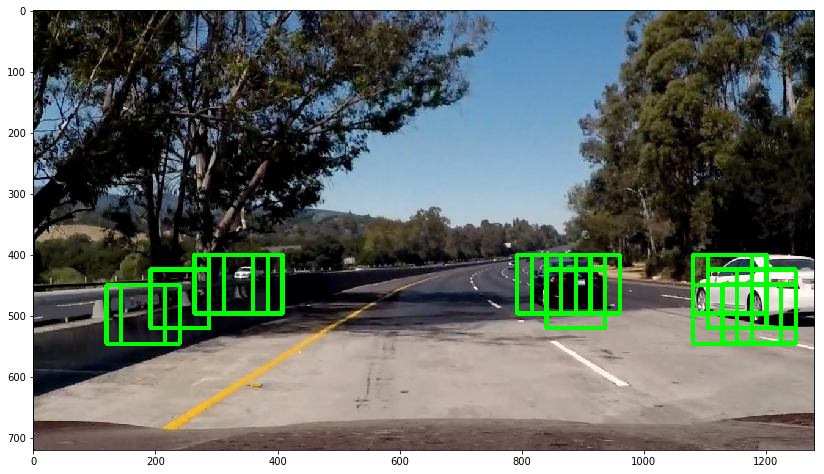

In [96]:
pict = mpimg.imread('./test_images/test5.jpg')
out_pict = np.copy(pict)

rectangles = []

ystart = 400
ystop = 700
xstart = 0
xstop = 1280
scale = 1.5

rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                     svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                     spatial_size, hist_bins, visualize_rectangles=False)
rectangles.extend(rects)

ystart = 450
ystop = 700
xstart = 0
xstop = 1280
scale = 1.5

rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                     svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                     spatial_size, hist_bins, visualize_rectangles=False)

rectangles.extend(rects)
test_out_img = draw_boxes(out_pict, rectangles, color=(0, 255, 0))
plt.figure(figsize=(14,14))
plt.imshow(test_out_img)
plt.savefig('./output_images/large_grid-3.png')

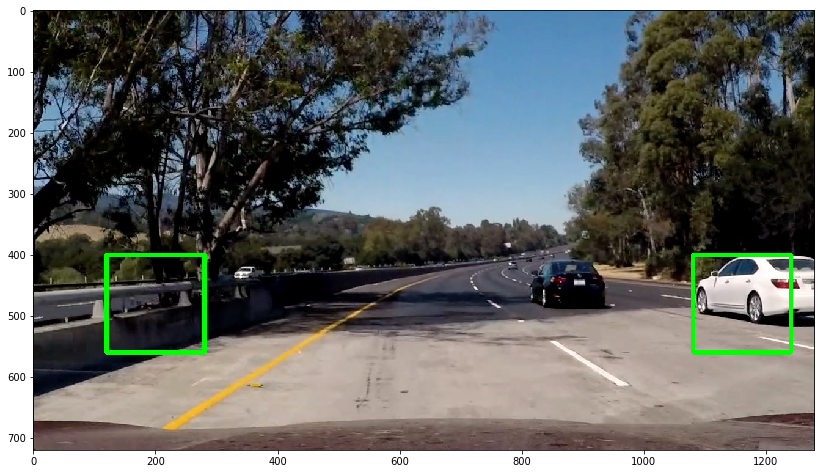

In [98]:
pict = mpimg.imread('./test_images/test5.jpg')
out_pict = np.copy(pict)

rectangles = []

ystart = 400
ystop = 700
xstart = 0
xstop = 1280
scale = 2.5

rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                     svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                     spatial_size, hist_bins, visualize_rectangles=False)
rectangles.extend(rects)

ystart = 450
ystop = 700
xstart = 0
xstop = 1280
scale = 2.5

rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                     svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                     spatial_size, hist_bins, visualize_rectangles=False)

rectangles.extend(rects)
test_out_img = draw_boxes(out_pict, rectangles, color=(0, 255, 0))
plt.figure(figsize=(14,14))
plt.imshow(test_out_img)
plt.savefig('./output_images/large_grid-4.png')

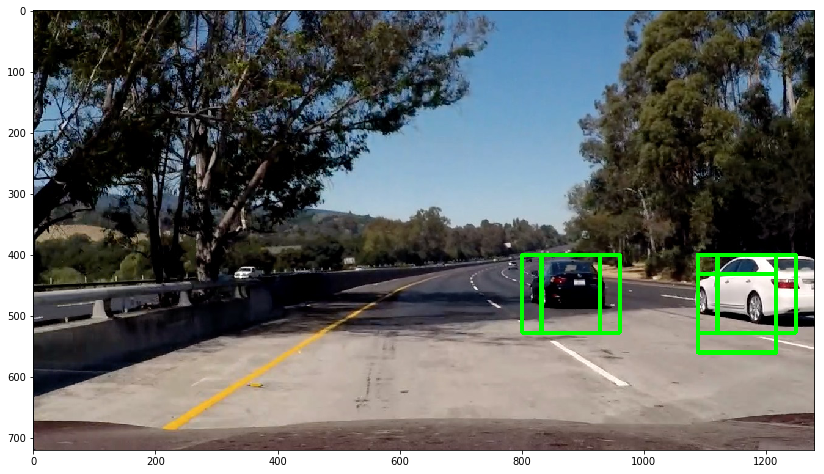

In [102]:
pict = mpimg.imread('./test_images/test5.jpg')
out_pict = np.copy(pict)

rectangles = []

ystart = 400
ystop = 700
xstart = 0
xstop = 1280
scale = 2.

rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                     svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                     spatial_size, hist_bins, visualize_rectangles=False)
rectangles.extend(rects)

ystart = 450
ystop = 700
xstart = 0
xstop = 1280
scale = 2.

rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                     svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                     spatial_size, hist_bins, visualize_rectangles=False)

rectangles.extend(rects)
test_out_img = draw_boxes(out_pict, rectangles, color=(0, 255, 0))
plt.figure(figsize=(14,14))
plt.imshow(test_out_img)
plt.savefig('./output_images/large_grid-5.png')

### Heatmap ###

In [133]:
# We do get some false positives along with overlapping windows
# lets screen these out using a heatmap
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255, 0, 0), 6)
    # Return the image
    return img

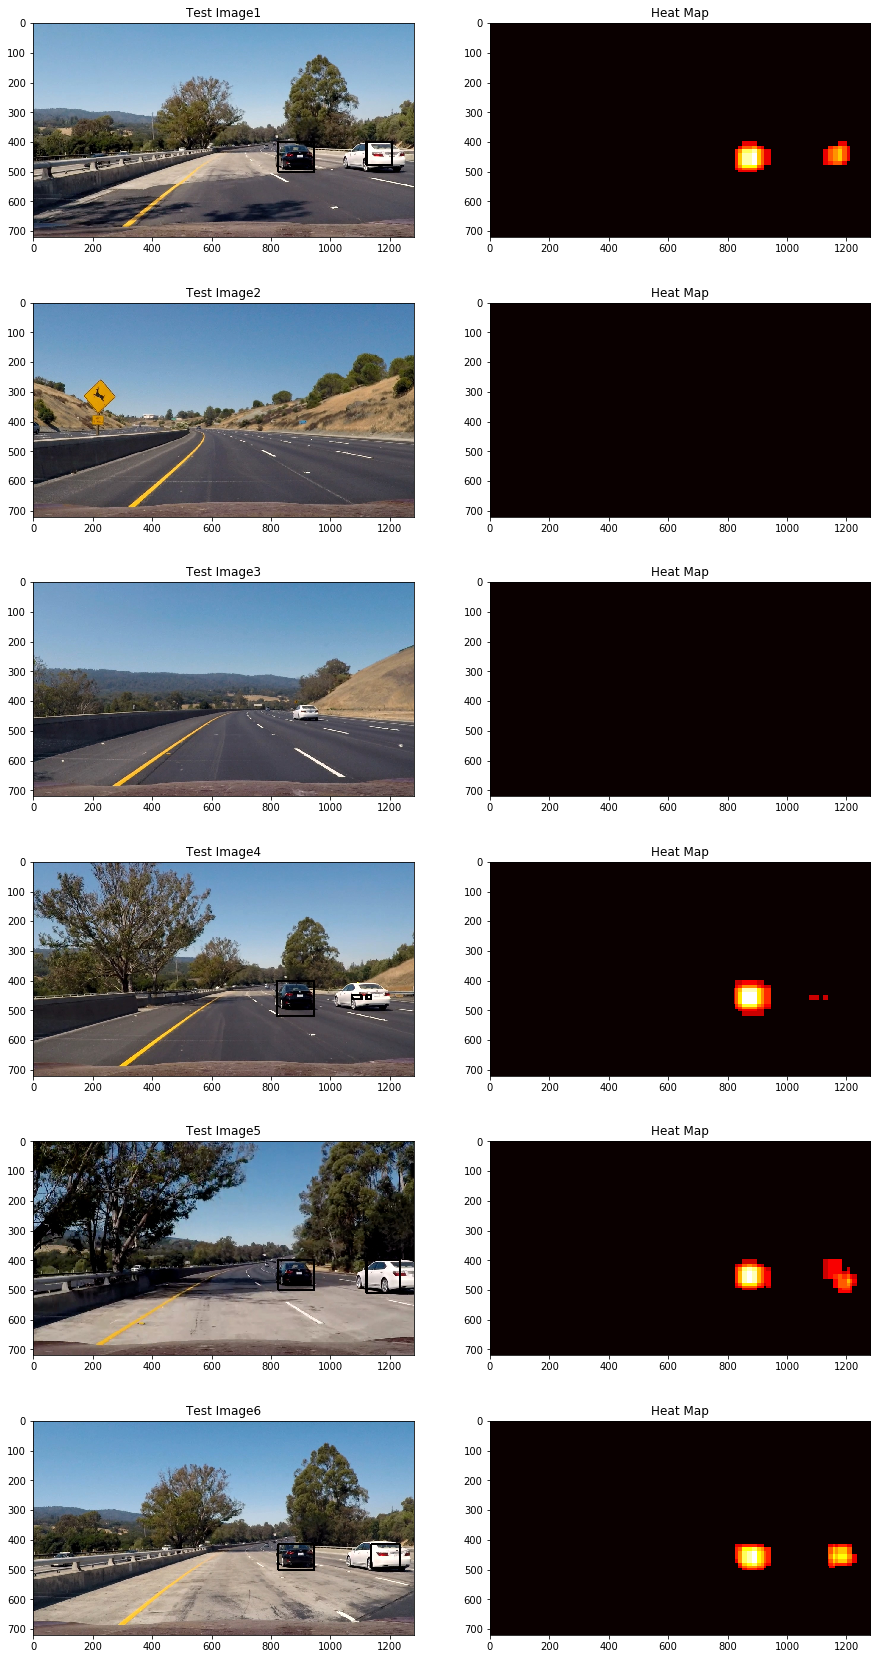

In [135]:


f, axs = plt.subplots(6,2,figsize=(15, 30))
for i, test in enumerate(glob.glob('./test_images/*.jpg')):
    pict = mpimg.imread(test)
    out_pict = np.copy(pict)
    # this is a jpg and we trained our classifier on .PNG format
    out_pict = out_pict.astype(np.float32)/255

    rectangles = []
    # put together grids
    # scale = 1.0
    #
    ystart = 400
    ystop = 500
    xstart = 0
    xstop = 1280
    scale = 1.

    rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                         svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                         spatial_size, hist_bins, visualize_rectangles=False)
    rectangles.extend(rects)

    ystart = 424
    ystop = 524
    xstart = 0
    xstop = 1280
    scale = 1.

    rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                         svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                         spatial_size, hist_bins, visualize_rectangles=False)

    rectangles.extend(rects)
    
    ystart = 450
    ystop = 550
    xstart = 0
    xstop = 1280
    scale = 1.

    rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                         svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                         spatial_size, hist_bins, visualize_rectangles=False)
    
    rectangles.extend(rects)
    
    # put together grids
    # scale = 1.5
    #
    #ystart = 400
    #ystop = 700
    #xstart = 0
    #xstop = 300
    #scale = 1.5

    #rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
    #                     svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
    #                     spatial_size, hist_bins, visualize_rectangles=False)
    #rectangles.extend(rects)
    
    ystart = 400
    ystop = 700
    xstart = 800
    xstop = 1280
    scale = 1.5

    rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                         svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                         spatial_size, hist_bins, visualize_rectangles=False)

    rectangles.extend(rects)

    ystart = 450
    ystop = 700
    xstart = 900
    xstop = 1280
    scale = 1.5

    rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                         svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                         spatial_size, hist_bins, visualize_rectangles=False)

    rectangles.extend(rects)
    
    # put together grids
    # scale = 2.0
    #
    #ystart = 400
    #ystop = 700
    #xstart = 0
    #xstop = 300
    #scale = 2.0

    #rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
    #                     svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
    #                     spatial_size, hist_bins, visualize_rectangles=False)
    #rectangles.extend(rects)
    
    ystart = 400
    ystop = 700
    xstart = 600
    xstop = 1280
    scale = 2.0

    rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                         svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                         spatial_size, hist_bins, visualize_rectangles=False)

    rectangles.extend(rects)

    ystart = 450
    ystop = 700
    xstart = 800
    xstop = 1280
    scale = 2.0

    rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                         svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                         spatial_size, hist_bins, visualize_rectangles=False)

    rectangles.extend(rects)
    
    # put together grids
    # scale = 2.5
    #
    ystart = 400
    ystop = 700
    xstart = 0
    xstop = 300
    scale = 2.5

    rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                         svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                         spatial_size, hist_bins, visualize_rectangles=False)
    rectangles.extend(rects)
    
    ystart = 400
    ystop = 700
    xstart = 700
    xstop = 1280
    scale = 2.5

    rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                         svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                         spatial_size, hist_bins, visualize_rectangles=False)

    rectangles.extend(rects)

    ystart = 450
    ystop = 700
    xstart = 800
    xstop = 1280
    scale = 2.5

    rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                         svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                         spatial_size, hist_bins, visualize_rectangles=False)

    rectangles.extend(rects)
    
    # create our blank heatmap
    heat = np.zeros_like(out_pict[:,:,0]).astype(np.float)
    # add heat from the detected car windows
    heat = add_heat(heat, rectangles)
    # Threshold the heatmap to get rid of false positives
    heat = apply_threshold(heat, 3)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(out_pict, labels)

    

    axs[i][0].imshow(draw_img)
    axs[i][0].set_title('Test Image' + str(i+1))
    
    axs[i][1].imshow(heatmap, cmap='hot')
    axs[i][1].set_title('Heat Map')

plt.savefig('./output_images/heatmaps.png')

In [170]:
class Video(object):
    def __init__(self):
        self.frame = 0
        self.num_heat = 2
        self.labels = None
        self.prev_heatmaps = []
        
    def update(self):
        self.frame += 1
        
    def addHeatmap(self, heat):
        self.prev_heatmaps.append(heat)
        heatlength = len(self.prev_heatmaps)
        if heatlength > self.num_heat:
            self.prev_heatmaps = self.prev_heatmaps[heatlength - self.num_heat:]

In [189]:
def pipeline(img):
    vid.update()
    draw_image = np.copy(img)
    # this is a jpg and we trained our classifier on .PNG format
    out_pict = img.astype(np.float32)/255
    if vid.frame == 1 or vid.frame % 3 == 0:
        

        rectangles = []
        # put together grids
        # scale = 1.0
        #
        ystart = 400
        ystop = 500
        xstart = 0
        xstop = 1280
        scale = 1.

        rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                             svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                             spatial_size, hist_bins, visualize_rectangles=False)
        rectangles.extend(rects)

        ystart = 424
        ystop = 524
        xstart = 0
        xstop = 1280
        scale = 1.

        rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                             svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                             spatial_size, hist_bins, visualize_rectangles=False)

        rectangles.extend(rects)
    
        #ystart = 450
        #ystop = 550
        #xstart = 0
        #xstop = 1280
        #scale = 1.

        #rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
        #                     svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
        #                     spatial_size, hist_bins, visualize_rectangles=False)
    
        #rectangles.extend(rects)
    
        # put together grids
        # scale = 1.5
        #
        #ystart = 400
        #ystop = 700
        #xstart = 0
        #xstop = 300
        #scale = 1.5

        #rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
        #                     svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
        #                     spatial_size, hist_bins, visualize_rectangles=False)
        #rectangles.extend(rects)
    
        #ystart = 400
        #ystop = 700
        #xstart = 800
        #xstop = 1280
        #scale = 1.5

        #rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
        #                     svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
        #                     spatial_size, hist_bins, visualize_rectangles=False)

        #rectangles.extend(rects)

        ystart = 450
        ystop = 700
        xstart = 900
        xstop = 1280
        scale = 1.5

        rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                             svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                             spatial_size, hist_bins, visualize_rectangles=False)

        rectangles.extend(rects)
    
        # put together grids
        # scale = 2.0
        #
        #ystart = 400
        #ystop = 700
        #xstart = 0
        #xstop = 300
        #scale = 2.0

        #rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
        #                     svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
        #                     spatial_size, hist_bins, visualize_rectangles=False)
        #rectangles.extend(rects)
    
        #ystart = 400
        #ystop = 700
        #xstart = 600
        #xstop = 1280
        #scale = 2.0

        #rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
        #                     svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
        #                     spatial_size, hist_bins, visualize_rectangles=False)

        #rectangles.extend(rects)

        ystart = 450
        ystop = 700
        xstart = 800
        xstop = 1280
        scale = 2.0

        rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                             svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                             spatial_size, hist_bins, visualize_rectangles=False)

        rectangles.extend(rects)
    
        # put together grids
        # scale = 2.5
        #
        ystart = 400
        ystop = 700
        xstart = 0
        xstop = 300
        scale = 2.5

        rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                             svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                             spatial_size, hist_bins, visualize_rectangles=False)
        rectangles.extend(rects)
    
        ystart = 400
        ystop = 700
        xstart = 800
        xstop = 1280
        scale = 2.5

        rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                             svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                             spatial_size, hist_bins, visualize_rectangles=False)

        rectangles.extend(rects)

        ystart = 450
        ystop = 700
        xstart = 900
        xstop = 1280
        scale = 2.5

        rects, _ = find_cars(out_pict, ystart, ystop, xstart, xstop, scale, 
                             svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, 
                             spatial_size, hist_bins, visualize_rectangles=False)

        rectangles.extend(rects)
    
        # create our blank heatmap
        heat = np.zeros_like(out_pict[:,:,0]).astype(np.float)
        # add heat from the detected car windows
        heat = add_heat(heat, rectangles)
        # Threshold the heatmap to get rid of false positives
        heat = apply_threshold(heat, 1)
        vid.addHeatmap(heat)
        heat = np.zeros_like(out_pict[:,:,0]).astype(np.float)
        #if vid.frame > 4:
        #    heat = np.logical_and(vid.prev_heatmaps[0], vid.prev_heatmaps[1])
        for hm in vid.prev_heatmaps:
            heat += hm
        heat = heat / 2
        heat = apply_threshold(heat, 4)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        vid.labels = labels
        draw_img = draw_labeled_bboxes(draw_image, labels)
        return draw_img
    else:
        draw_img = draw_labeled_bboxes(draw_image, vid.labels)
        return draw_img


In [190]:
vid = Video()
output = './test_video_output.mp4'
cliptest = VideoFileClip("./test_video.mp4")
clip = cliptest.fl_image(pipeline)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./test_video_output.mp4
[MoviePy] Writing video ./test_video_output.mp4


 97%|█████████▋| 38/39 [00:07<00:00,  5.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_output.mp4 

CPU times: user 7.69 s, sys: 80 ms, total: 7.77 s
Wall time: 9.17 s


In [191]:
vid = Video()
output = './project_video_output.mp4'
cliptest = VideoFileClip("./project_video.mp4")
clip = cliptest.fl_image(pipeline)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████▉| 1260/1261 [05:08<00:00,  4.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

CPU times: user 5min 9s, sys: 3.46 s, total: 5min 13s
Wall time: 5min 10s
